In [62]:
# ライブラリのインポート
import numpy as np
from sklearn.metrics import r2_score
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [93]:
# 交通量データの読込み
npyname = "kddi_06_new"
datedir = "230316"

In [94]:
timeseries_aug = np.load("./" + datedir+'/'+ npyname + "_01param.npy", allow_pickle=True)

In [95]:
# 読み込んだ交通量データの確認
timeseries_aug.shape

(720, 16814)

In [96]:
# 読み込んだ交通量データの確認
timeseries_aug

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [97]:
# データの正規化
# データを0～1の範囲に正規化）
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(timeseries_aug)
scaled_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [98]:
# scalerの保存
import joblib
joblib.dump(scaler, datedir+'/'+ npyname + '_scaler.gz')
# 保存したScalerの読込み
# load_scaler = joblib.load('scaler.gz')

['230316/kddi_06_new_scaler.gz']

In [99]:
# データサイズの確認
scaled_data.shape

(720, 16814)

In [100]:
# トレーニングデータの大きさを取得
# 全体の80%をトレーニングデータとして扱う）
training_data_len = int(np.ceil(len(timeseries_aug) * 1))

In [101]:
# トレーニングデータの大きさを確認
training_data_len

720

In [102]:
# どれくらいの期間を基に予測するか　（例：★ここでは24
window_size = 24
train_data = scaled_data[0:int(training_data_len), :]
train_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [103]:
# データサイズの確認
train_data.shape

(720, 16814)

In [104]:
x_train = []
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, :])


In [105]:
# 訓練（学習）データと教師（正解）データをnumpy arrayに変換
x_train = np.array(x_train)

In [106]:
# numpy_array変換後（訓練（学習）データ）【参考】https://qiita.com/ken_yoshi/items/4cbe3abb7d46c5252fdd
print(x_train.shape)
x_train

(696, 24, 16814)


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [107]:
# （AE）数ヵ所の観測点から全体の推測
# （モデル作成）
model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
# (Encoder)
model.add(LSTM(64, activation='relu', return_sequences=False))
# (Bridge)
model.add(RepeatVector(x_train.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
# (Decoder)
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(units=x_train.shape[2])))

model.compile(optimizer='adam', loss='mean_squared_error')
# モデルの視覚化
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)
history = model.fit(x_train, x_train, batch_size=8, epochs=30)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/30
87/87 [==============================] - 18s 182ms/step - loss: 0.0046
Epoch 2/30
87/87 [==============================] - 16s 184ms/step - loss: 0.0045
Epoch 3/30
87/87 [==============================] - 16s 187ms/step - loss: 0.0045
Epoch 4/30
87/87 [==============================] - 16s 187ms/step - loss: 0.0044
Epoch 5/30
87/87 [==============================] - 16s 185ms/step - loss: 0.0044
Epoch 6/30
87/87 [==============================] - 16s 187ms/step - loss: 0.0044
Epoch 7/30
87/87 [==============================] - 16s 186ms/step - loss: 0.0044
Epoch 8/30
87/87 [==============================] - 16s 187ms/step - loss: 0.0043
Epoch 9/30
87/87 [==============================] - 16s 185ms/step - loss: 0.0044
Epoch 10/30
87/87 [==============================] - 16s 185ms/step - loss: 0.0043
Epoch 11/30
87/87

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 24, 128)           8674816   
                                                                 
 dropout_3 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 24, 64)           0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 24, 64)            33024     
                                                                 
 lstm_15 (LSTM)              (None, 24, 128)           98816     
                                                      

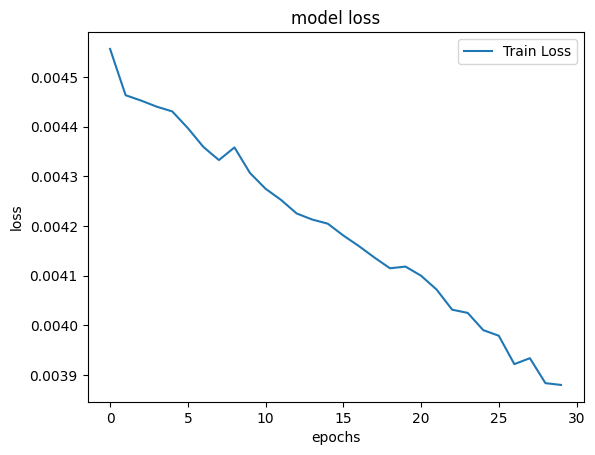

In [108]:
# モデルの概要
model.summary()

import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

# 検証

In [109]:
# データ構造を再確認 
print(training_data_len)
print(window_size)

720
24


In [110]:
# テストデータを作成
test_data = scaled_data[training_data_len - window_size: , :]

In [111]:
# テストデータの構造を確認
test_data.shape

(24, 16814)

In [112]:
x_test ={}
# （正解判定用）
y_test = timeseries_aug[window_size:, :]

In [113]:
# 正解データの構造を確認
y_test.shape

(696, 16814)

In [114]:
# テスト用予測データ
x_test = []
for i in range(0, len(test_data)):
    ##  timestep 24hの場合：0 → 24, 1 → 25 ・・・
    x_test.append(test_data[i-window_size:i, :])

In [115]:
# データの確認（予測用）
x_test[0]

array([], shape=(0, 16814), dtype=float64)

In [116]:
# データの確認（正解）
y_test[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [117]:
# numpy_arrayに変換
x_test = np.array(x_test)
print(x_test.shape)

(24, 0, 16814)


In [118]:
# 予測実行
predictions = model.predict(x_train)

22/22 [==============================] - 2s 57ms/step


In [119]:
# 予測結果を確認
print(predictions.shape)
predictions

(696, 24, 16814)


array([[[ 7.17828516e-06, -6.73769508e-04,  2.26796861e-03, ...,
         -2.78287660e-03,  1.28856231e-03,  5.81815280e-03],
        [ 7.03112455e-04, -3.30961542e-03,  9.14974371e-04, ...,
         -2.61206063e-03,  2.03201594e-03,  1.30928438e-02],
        [ 1.27784570e-03, -4.75327298e-03, -1.61825097e-03, ...,
         -2.15111068e-04,  4.20908397e-03,  1.75839663e-02],
        ...,
        [ 1.87778019e-03, -3.07758572e-04, -2.06965618e-02, ...,
          1.93620473e-03, -2.27195956e-03, -2.91968626e-03],
        [ 2.10442115e-04,  1.39489910e-03, -2.07841825e-02, ...,
          3.25118843e-03, -7.71508436e-04, -2.59569311e-03],
        [-4.56204871e-05, -1.03290426e-04, -1.03185540e-02, ...,
         -1.93590764e-04,  1.26739545e-03,  3.15290736e-03]],

       [[ 8.42831214e-05, -1.24291983e-03,  1.88527012e-03, ...,
         -2.07922631e-03,  1.24320807e-03,  8.49450566e-03],
        [ 1.14098447e-03, -4.75078821e-03,  2.65417504e-04, ...,
         -7.93053186e-04,  3.73944640e

In [120]:
# 正解データを確認
print(y_test.shape)
y_test

(696, 16814)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [121]:
# 結果をそれぞれ出力
np.save(datedir+'/'+ npyname + '_predictions.npy', predictions)
np.save(datedir+'/'+ npyname + '_y_test.npy', y_test)

In [122]:
# モデルの保存　⇔ モデルの読込み model = load_model('traffic_pattern.h5')
model.save(datedir+'/'+ npyname + '_model.h5')
# import keras
# model = keras.models.load_model('traffic_pattern_b.h5')